In [56]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

In [57]:
# helper function to convert a desired value to a circuit type
def convertToCircuit(val):
    # does some garbage
    U = QuantumCircuit(4)
    
    if val >= 8:
        U.x(0)
    if val % 8 >= 4:
        U.x(1)
    if val % 4 >= 2:
        U.x(2)
    if val % 2 == 0:
        U.x(3)
    
#     U = U.to_gate()
#     U.name = "%i^%i mod %i" % (a, power)
#     c_U = U.control()
#     return c_U
    return U

In [58]:
# testing this potentially better amodn function
def amodn(a, n, power):
    # U = QuantumCircuit(4)
    U = convertToCircuit(pow(a, power, n))
    U = U.to_gate()
    U.name = "%i^%i mod %i" % (a, power, n)
    c_U = U.control()
    return c_U

In [20]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
#     if a not in [2,7,8,11,13]:
#         raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [90]:
# Specify variables
n_count = 8  # number of counting qubits
a = 3

In [91]:
N = 14

In [92]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [93]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialise counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(amodn(a, N, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                                                                                                             ┌───────┐┌─┐                     
 q_0: ┤ H ├───────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├─────────────────────
      ├───┤       │                                                                                                                     │       │└╥┘┌─┐                  
 q_1: ┤ H ├───────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├──────────────────
      ├───┤       │              │                                                                                                      │       │ ║ └╥┘┌─┐               
 q_2: ┤ H ├───────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├───────────────
      ├───┤       │              │              │                                                                                       │       │ ║  ║ └╥┘┌─┐            
 q_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├────────────
      ├───┤       │              │              │              │                                                                        │  QFT† │ ║  ║  ║ └╥┘┌─┐         
 q_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■─────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├─────────
      ├───┤       │              │              │              │              │                                                         │       │ ║  ║  ║  ║ └╥┘┌─┐      
 q_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■─────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├──────
      ├───┤       │              │              │              │              │               │                                         │       │ ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■─────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤       │              │              │              │              │               │               │                         │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐
 q_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├
      └───┘┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐┌──────┴───────┐┌──────┴───────┐┌──────┴───────┐┌───────┴───────┐└───────┘ ║  ║  ║  ║  ║  ║  ║ └╥┘
 q_8: ─────┤0            ├┤0            ├┤0            ├┤0            ├┤0             ├┤0             ├┤0             ├┤0              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
 q_9: ─────┤1            ├┤1            ├┤1            ├┤1            ├┤1             ├┤1             ├┤1             ├┤1              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
           │  3^1 mod 14 ││  3^2 mod 14 ││  3^4 mod 14 ││  3^8 mod 14 ││  3^16 mod 14 ││  3^32 mod 14 ││  3^64 mod 14 ││  3^128 mod 14 │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_10: ─────┤2            ├┤2            ├┤2            ├┤2            ├┤2             ├┤2             ├┤2             ├┤2              ├──────────╫──╫──╫──╫──╫──╫──╫──╫─
      ┌───┐│             ││             ││             ││             ││              ││              ││              ││               │          ║  ║  ║  ║  ║  ║  ║  ║ 
q_11: ┤ X ├┤3            ├┤3            ├┤3            ├┤3            ├┤3             ├┤3       

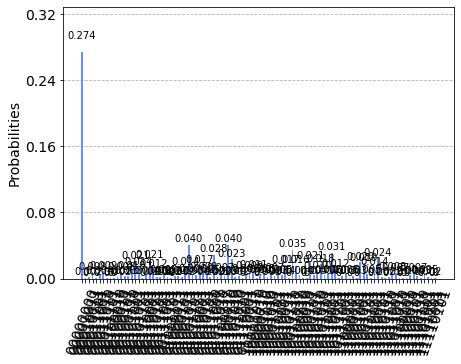

In [94]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [95]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

             Register Output           Phase
0   00000000(bin) =   0(dec)    0/256 = 0.00
1   00010011(bin) =  19(dec)   19/256 = 0.07
2   00010101(bin) =  21(dec)   21/256 = 0.08
3   00011001(bin) =  25(dec)   25/256 = 0.10
4   00011010(bin) =  26(dec)   26/256 = 0.10
..                       ...             ...
95  11101001(bin) = 233(dec)  233/256 = 0.91
96  11101011(bin) = 235(dec)  235/256 = 0.92
97  11101101(bin) = 237(dec)  237/256 = 0.93
98  11110011(bin) = 243(dec)  243/256 = 0.95
99  11110101(bin) = 245(dec)  245/256 = 0.96

[100 rows x 2 columns]


In [96]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(N)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

       Phase Fraction  Guess for r
0   0.000000      0/1            1
1   0.074219     1/13           13
2   0.082031     1/12           12
3   0.097656     1/10           10
4   0.101562     1/10           10
..       ...      ...          ...
95  0.910156    10/11           11
96  0.917969    11/12           12
97  0.925781    12/13           13
98  0.949219    13/14           14
99  0.957031    13/14           14

[100 rows x 3 columns]


In [97]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a

In [98]:
from math import gcd # greatest common divisor
gcd(a, N)

1

In [99]:
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialise counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(amodn(a, N, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    qasm_sim = Aer.get_backend('qasm_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, qasm_sim)
    obj = assemble(t_qc, shots=1)
    result = qasm_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [100]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r

Register Reading: 00000000
Corresponding Phase: 0.000000


Fraction(0, 1)

In [101]:
frac = Fraction(phase).limit_denominator(N)
s, r = frac.numerator, frac.denominator
print(r)

1


In [102]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[14, 2]


In [104]:
# for a in range(2, 14):
# a = 5
print("trying " + str(a))
factor_found = False
attempt = 0
while not factor_found and attempt <= 30:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True               
print("----------------------")

trying 3

Attempt 1:
Register Reading: 00000000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 2:
Register Reading: 00000000
Corresponding Phase: 0.000000
Result: r = 1

Attempt 3:
Register Reading: 01100110
Corresponding Phase: 0.398438
Result: r = 5
Guessed Factors: 2 and 2
*** Non-trivial factor found: 2 ***
*** Non-trivial factor found: 2 ***
----------------------
